1. Попробуйте обучить нейронную сеть RNN/LSTM/GRU на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). 

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [149]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, SimpleRNN

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

import os
import datetime

In [150]:
def normalize(data, data_mean=0, data_std=0):
    if data_std == 0:
        data_mean = data.mean(axis=0)
        data_std = data.std(axis=0)
    return (data - data_mean) / data_std, data_mean,data_std

In [151]:
df = pd.read_csv('airline-passengers.csv', index_col=0)
df.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [152]:
df.sort_index(ascending=True, inplace=True)
df.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


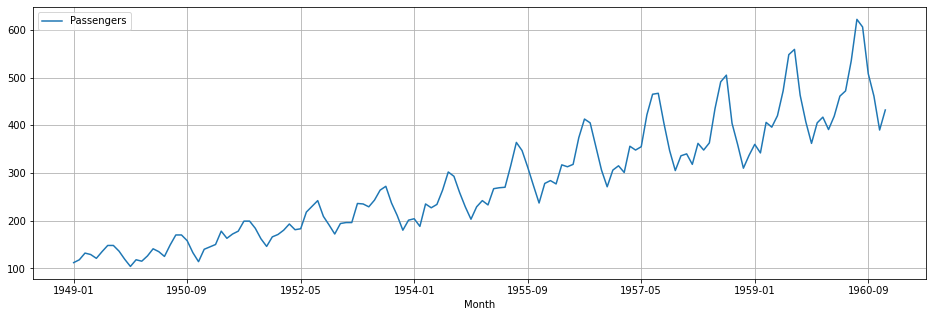

In [153]:
df.plot(figsize = (16, 5))

plt.grid('On')
plt.show()

In [154]:
df['month'] = pd.to_datetime(df.index).month
df['year'] = pd.to_datetime(df.index).year - 1949
df.head()

,Passengers,month,year
Month,,,
1949-01,112,1,0
1949-02,118,2,0
1949-03,132,3,0
1949-04,129,4,0
1949-05,121,5,0


In [155]:
for year_n in df['year'].unique():
    print(np.argmax(df.loc[df['year'] == year_n, 'Passengers']))

6
6
6
7
7
6
6
6
7
7
7
6


In [156]:
df['is_top_month'] = 0
df.loc[df['month'] == 7, 'is_top_month'] = 1
df.loc[df['month'] == 8, 'is_top_month'] = 1
df.head(12)

,Passengers,month,year,is_top_month
Month,,,,
1949-01,112,1,0,0
1949-02,118,2,0,0
1949-03,132,3,0,0
1949-04,129,4,0,0
1949-05,121,5,0,0
1949-06,135,6,0,0
1949-07,148,7,0,1
1949-08,148,8,0,1
1949-09,136,9,0,0


In [157]:
data = df.copy()

In [158]:
data.head()

,Passengers,month,year,is_top_month
Month,,,,
1949-01,112,1,0,0
1949-02,118,2,0,0
1949-03,132,3,0,0
1949-04,129,4,0,0
1949-05,121,5,0,0


In [159]:
train_split = 120
_,d_m,d_s =  normalize(data.iloc[:train_split, 0].values)
data.iloc[:, 0] = (data.iloc[:, 0].values-d_m) / d_s

In [160]:
data.head()

,Passengers,month,year,is_top_month
Month,,,,
1949-01,-1.416335,1,0,0
1949-02,-1.352874,2,0,0
1949-03,-1.204797,3,0,0
1949-04,-1.236528,4,0,0
1949-05,-1.321143,5,0,0


In [161]:
channelIndexes = [0, 1, 2, 3]

val_len = 24
x_len = 3
bias = 9

train_data = data.iloc[0 : train_split, channelIndexes]
val_data = data.iloc[train_split+bias:, channelIndexes]

In [162]:
train_data.head(3)

,Passengers,month,year,is_top_month
Month,,,,
1949-01,-1.416335,1,0,0
1949-02,-1.352874,2,0,0
1949-03,-1.204797,3,0,0


In [163]:
step = 1

past = x_len
p = past
future = 1
h = future

learning_rate = 0.001
batch_size = 24
epochs = 10

In [165]:
Chanel_numb = len(channelIndexes)

start = x_len + future
end = start + train_split-1

x_train_df = train_data.iloc[:-future-x_Len+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
x_train = x_train_df[[train_data.columns[i] for i in range(Chanel_numb)]].values
y_train = train_data.iloc[future+x_len-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

sequence_length = int(x_len / step)


x_end = len(val_data) - x_len - future 

label_start = len(train_data) + bias + x_len + future + 1

x_val_df = val_data.iloc[:-future-x_len+1, :] # сдвиг по времени для предсказания (закончить чуть раньше)
x_val = x_val_df[[val_data.columns[i] for i in range(Chanel_numb)]].values
y_val = val_data.iloc[future+x_len-1:, 0].values  # сдвиг по времени для предсказания (начать чуть позднее)

In [166]:
xTrain.shape, yTrain.shape, xVal.shape, yVal.shape

((117, 4), (117,), (12, 4), (12,))

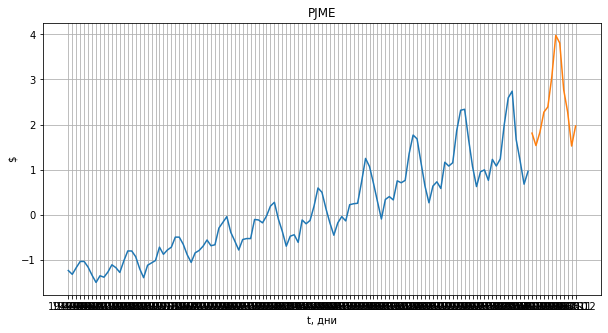

In [167]:
plt.figure(figsize=(10, 5))
plt.plot(data.index[x_len:y_train.shape[0]+x_len], y_train[:])
plt.plot(data.index[y_train.shape[0]+bias+future+2*x_len-1:], y_val[:])
plt.grid('on')
plt.xlabel('t, дни')
plt.ylabel('$')
plt.title('PJME')
plt.show()

In [168]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

In [169]:
for batch in dataset_val.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (10, 3, 4)
Target shape: (10,)


In [170]:
for batch in dataset_train.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (24, 3, 4)
Target shape: (24,)


In [171]:
logdir = os.path.join("logs2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard( logdir, histogram_freq=1)

In [172]:
early_stop = EarlyStopping(monitor='val_mae', 
                           patience=5,
                           restore_best_weights=True)

In [173]:
model_1 = Sequential()
model_1.add(SimpleRNN(256, 
                      input_shape=(inputs.shape[1], inputs.shape[2]),
                      return_sequences=True))

model_1.add(Flatten())

model_1.add(Dense(128, activation='linear'))
model_1.add(Dense(64, activation='linear'))
model_1.add(Dense(32, activation='linear'))
model_1.add(Dense(1, activation='linear'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001) 

model_1.compile(loss='mse', optimizer=opt, metrics=['mae'])
model_1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 3, 256)            66816     
                                                                 
 flatten_6 (Flatten)         (None, 768)               0         
                                                                 
 dense_21 (Dense)            (None, 128)               98432     
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dense_24 (Dense)            (None, 1)                 33        
                                                                 
Total params: 175,617
Trainable params: 175,617
Non-tr

In [174]:
history_1 = model_1.fit(dataset_train,
                        epochs=50,
                        validation_data=dataset_val,
                        verbose=0,
                        callbacks=[early_stop]
                       )

test_loss, test_metric = model_1.evaluate(dataset_val)
print(f"Test loss {test_loss}, Test mae {test_metric}")

1/1 [==============================] - 0s 59ms/step - loss: 1.0106 - mae: 0.8501
Test loss 1.0106146335601807, Test mae 0.8501183390617371


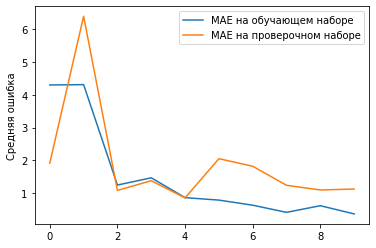

In [175]:
plt.plot(history_1.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_1.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [176]:
pred = model_1.predict(dataset_train).flatten()
pred_val = model_1.predict(dataset_val).flatten()

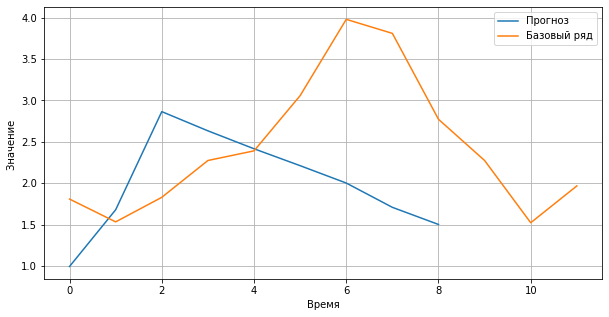

In [177]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val[future + start: future+start+step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

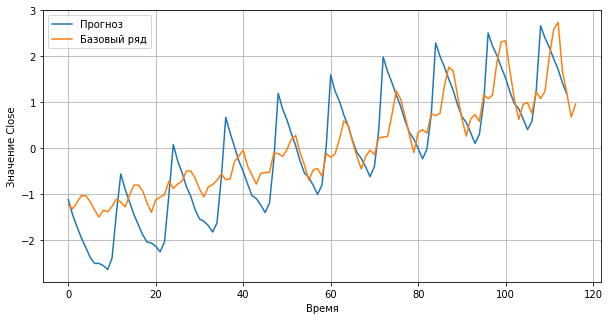

In [178]:
start = 0

plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred[start: train_split], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_split], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

Epoch 1/10
5/5 [==============================] - 5s 275ms/step - loss: 1.1914 - mae: 0.9039 - val_loss: 7.4350 - val_mae: 2.6230
Epoch 2/10
5/5 [==============================] - 0s 40ms/step - loss: 0.7486 - mae: 0.6943 - val_loss: 5.5494 - val_mae: 2.2410
Epoch 3/10
5/5 [==============================] - 0s 41ms/step - loss: 0.5255 - mae: 0.5936 - val_loss: 3.6504 - val_mae: 1.7770
Epoch 4/10
5/5 [==============================] - 0s 40ms/step - loss: 0.3759 - mae: 0.5099 - val_loss: 2.0235 - val_mae: 1.2577
Epoch 5/10
5/5 [==============================] - 0s 40ms/step - loss: 0.2723 - mae: 0.4356 - val_loss: 1.0262 - val_mae: 0.8057
Epoch 6/10
5/5 [==============================] - 0s 43ms/step - loss: 0.1975 - mae: 0.3336 - val_loss: 0.6826 - val_mae: 0.5899
Epoch 7/10
5/5 [==============================] - 0s 59ms/step - loss: 0.2192 - mae: 0.3949 - val_loss: 0.7294 - val_mae: 0.6228
Epoch 8/10
5/5 [==============================] - 0s 47ms/step - loss: 0.1697 - mae: 0.3343 - va

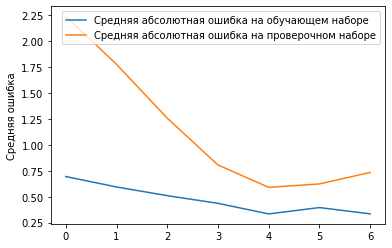

In [179]:
callbaсk = EarlyStopping(monitor='val_mae', patience=2)

model = Sequential()

model.add(LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(64, return_sequences="True")) 
model.add(Conv1D(64, 3, activation="linear"))
model.add(Flatten())                          
model.add(Dense(3, activation="linear"))      

model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback])


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [180]:
hist_val = history.history['val_mae']
hist_train = history.history['mae']

Epoch 1/10
5/5 [==============================] - 1s 40ms/step - loss: 0.1430 - mae: 0.2814 - val_loss: 1.0578 - val_mae: 0.8186
Epoch 2/10
5/5 [==============================] - 0s 36ms/step - loss: 0.1343 - mae: 0.2688 - val_loss: 1.0044 - val_mae: 0.7916
Epoch 3/10
5/5 [==============================] - 0s 36ms/step - loss: 0.1142 - mae: 0.2537 - val_loss: 0.7576 - val_mae: 0.6327
Epoch 4/10
5/5 [==============================] - 0s 36ms/step - loss: 0.1048 - mae: 0.2573 - val_loss: 0.5621 - val_mae: 0.5229
Epoch 5/10
5/5 [==============================] - 0s 36ms/step - loss: 0.1002 - mae: 0.2567 - val_loss: 0.5369 - val_mae: 0.5130
Epoch 6/10
5/5 [==============================] - 0s 36ms/step - loss: 0.0918 - mae: 0.2397 - val_loss: 0.5566 - val_mae: 0.5296
Epoch 7/10
5/5 [==============================] - 0s 39ms/step - loss: 0.0843 - mae: 0.2239 - val_loss: 0.4939 - val_mae: 0.4976
Epoch 8/10
5/5 [==============================] - 0s 43ms/step - loss: 0.0781 - mae: 0.2173 - val

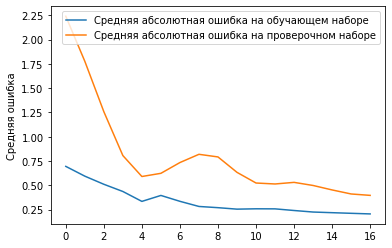

In [181]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback])

hist_val.extend(history.history['val_mae'][:])
hist_train.extend(history.history['mae'][:])

plt.plot(hist_train[1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(hist_val[1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [182]:
pred = model.predict(dataset_train).flatten()
pred_val = model.predict(dataset_val).flatten()

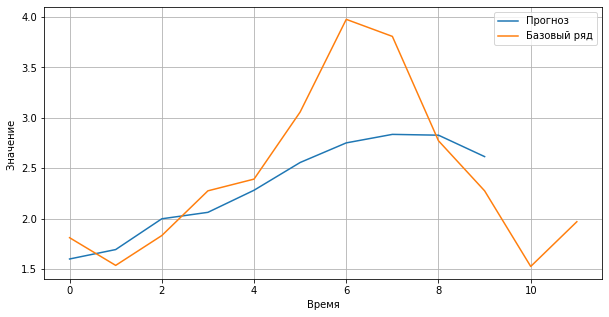

In [183]:
start = 0
step = 144
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred_val[start:start+step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

In [184]:
model = Sequential()
model.add(GRU(524, 
                input_shape=(inputs.shape[1], inputs.shape[2]),
                return_sequences=True))

model.add(Conv1D(256, 3, activation='linear'))

model.add(Flatten())

model.add(Dense(64, activation='linear'))
model.add(Dense(32, activation='linear'))
model.add(Dense(1, activation='linear'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001) 

model.compile(loss='mse', optimizer=opt, metrics=['mae'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 3, 524)            833160    
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 256)            402688    
                                                                 
 flatten_8 (Flatten)         (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 64)                16448     
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,254,409
Trainable params: 1,254,409
N

In [185]:
history = model.fit(dataset_train,
                      epochs=50,
                      validation_data=dataset_val,
                      verbose=0,
                      callbacks=[early_stop]
                     )

test_loss, test_metric = model.evaluate(dataset_val)
print(f"Test loss {test_loss}, Test mae {test_metric}")

1/1 [==============================] - 0s 56ms/step - loss: 0.1625 - mae: 0.2960
Test loss 0.16245509684085846, Test mae 0.29604387283325195


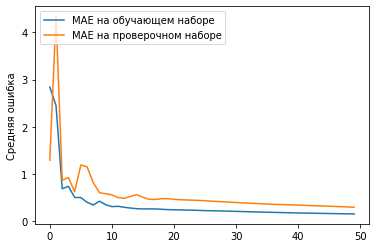

In [186]:
plt.plot(history.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend(loc='upper left')
plt.show()

In [187]:
pred = model.predict(dataset_train).flatten()
pred_val = model.predict(dataset_val).flatten()

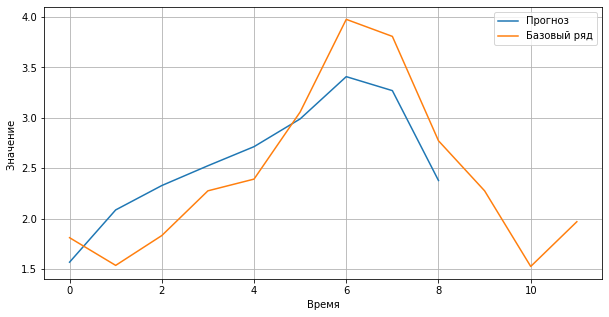

In [188]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

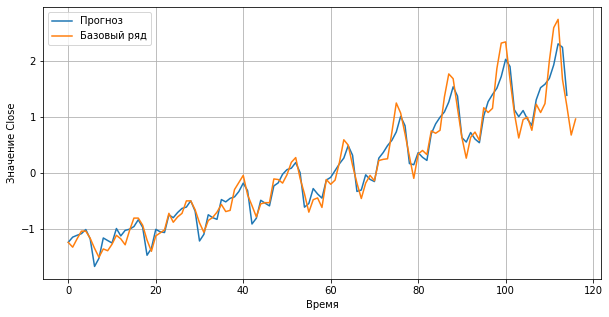

In [189]:
start = 0

plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred[start:train_split], 
         label='Прогноз')
plt.plot(y_train.flatten()[start:train_split], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()